# Facial Expression Recognition Transfer


In [ ]:
!pip install poutyne
!pip install torchsummary

In [1]:
import os
import tarfile
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms.functional import InterpolationMode
import torchvision.models as models

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment
from zipfile import ZipFile
from torchsummary import summary

In [2]:
set_seeds(42)

We download the dataset.

In [3]:
base_path = './datasets/facial_recognition'
zip_file_name = 'facial_expressions.zip'
base_image_path = os.path.join(base_path, 'images')
download_url = 'https://storage.googleapis.com/unsw_comp9444/facial_expressions/facial_expressions.zip'

In [4]:
def download_and_extract_dataset(base_path, extract_path, file_name, url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)

    print('Downloading dataset...')
    urllib.request.urlretrieve(url, zip_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, download_url)    

Extracting archive...


In [5]:
augment_transform = transforms.Compose(
    [                
        #transforms.Resize(224, interpolation=InterpolationMode.BILINEAR), 
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 2),
        #transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomPerspective(),   
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

normalize_transform = transforms.Compose(
    [        
        #transforms.Resize(224, interpolation=InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
test_image_path = os.path.join(base_image_path, 'test')

train_dataset = ImageFolder(
    train_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_valid_dataset = ImageFolder(
    test_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

In [6]:
print(train_dataset.class_to_idx)
print(test_valid_dataset[0][0])

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
tensor([[[0.1804, 0.1333, 0.1020,  ..., 0.0392, 0.0510, 0.0863],
         [0.1961, 0.1098, 0.0824,  ..., 0.0431, 0.0392, 0.0824],
         [0.1961, 0.1059, 0.0588,  ..., 0.0863, 0.0941, 0.0863],
         ...,
         [0.8157, 0.7020, 0.4235,  ..., 0.7490, 0.8039, 0.8000],
         [0.8314, 0.7765, 0.5843,  ..., 0.7098, 0.7843, 0.8000],
         [0.8157, 0.7882, 0.6706,  ..., 0.6471, 0.7059, 0.7412]],

        [[0.1804, 0.1333, 0.1020,  ..., 0.0392, 0.0510, 0.0863],
         [0.1961, 0.1098, 0.0824,  ..., 0.0431, 0.0392, 0.0824],
         [0.1961, 0.1059, 0.0588,  ..., 0.0863, 0.0941, 0.0863],
         ...,
         [0.8157, 0.7020, 0.4235,  ..., 0.7490, 0.8039, 0.8000],
         [0.8314, 0.7765, 0.5843,  ..., 0.7098, 0.7843, 0.8000],
         [0.8157, 0.7882, 0.6706,  ..., 0.6471, 0.7059, 0.7412]],

        [[0.1804, 0.1333, 0.1020,  ..., 0.0392, 0.0510, 0.0863],
         [0.1961, 0.1098, 0.0824, 

In [7]:
# We take 80% of the dataset for the training dataset
test_dataset_size = int(len(test_valid_dataset) * 0.5)
dataset_lengths = [test_dataset_size, len(test_valid_dataset) - test_dataset_size]
test_dataset, valid_dataset = random_split(test_valid_dataset, dataset_lengths)

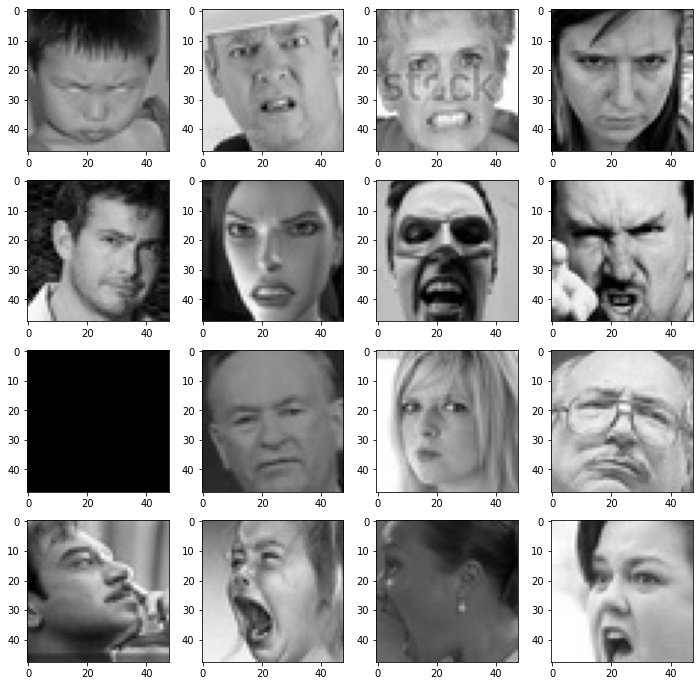

In [8]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, (image, label) in enumerate(dataset):
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0))
        if i >= 15:
            break
            
show_batch(train_dataset)          

In [9]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

28709
3589
3589


In [10]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 7
batch_size = 32
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.0001
n_epoch = 60
image_size = 48

Creation of the PyTorch's dataloader to split our data into batches.

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

In [12]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.vgg16_features = models.vgg16(pretrained=True).features
        #print(self.vgg16_features)
        #self.vgg16_pretrained.classifier = nn.Identity()

        for name, parameter in self.vgg16_features.named_parameters():
            parameter.requires_grad = False
            #if not(name.startswith('24') or name.startswith('26') or name.startswith('28')):
            #    parameter.requires_grad = False
            #    pass

        self.dropout_vgg = nn.Dropout(0.2)
        self.bn_vgg = nn.BatchNorm1d(512)
            
        self.fc1 = nn.Linear(512, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        #self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc_output = nn.Linear(128, num_classes)
        
    def forward(self, input):    
        output = self.vgg16_features(input)       
        output = self.dropout_vgg(output)   
        
        # Flattening process
        output = torch.flatten(output, start_dim=1)
        output = self.bn_vgg(output)
        
        output = F.relu(self.fc1(output))
        #output = self.bn_fc1(output))  
    
        output = self.fc_output(output)
        
        return output
    
cnn = CNN().to(device)
#print(summary(cnn, input_size=(3, image_size, image_size)))    
print(summary(cnn.vgg16_features, input_size=(3, image_size, image_size)))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

In [13]:
for name, parameter in cnn.named_parameters():
    print(f'{name}, {parameter.requires_grad}')

vgg16_features.0.weight, False
vgg16_features.0.bias, False
vgg16_features.2.weight, False
vgg16_features.2.bias, False
vgg16_features.5.weight, False
vgg16_features.5.bias, False
vgg16_features.7.weight, False
vgg16_features.7.bias, False
vgg16_features.10.weight, False
vgg16_features.10.bias, False
vgg16_features.12.weight, False
vgg16_features.12.bias, False
vgg16_features.14.weight, False
vgg16_features.14.bias, False
vgg16_features.17.weight, False
vgg16_features.17.bias, False
vgg16_features.19.weight, False
vgg16_features.19.bias, False
vgg16_features.21.weight, False
vgg16_features.21.bias, False
vgg16_features.24.weight, False
vgg16_features.24.bias, False
vgg16_features.26.weight, False
vgg16_features.26.bias, False
vgg16_features.28.weight, False
vgg16_features.28.bias, False
bn_vgg.weight, True
bn_vgg.bias, True
fc1.weight, True
fc1.bias, True
bn_fc1.weight, True
bn_fc1.bias, True
fc_output.weight, True
fc_output.bias, True


We define callbacks for saving last epoch, best epoch and logging the results.

In [14]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'fer_faces_vgg')
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [15]:
trainable_parameters = (parameter for name, parameter in cnn.named_parameters() if parameter.requires_grad)
optimizer = optim.Adam(trainable_parameters, lr=learning_rate)

loss_function = nn.CrossEntropyLoss()

model = Model(
    cnn,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks    
)

test_loss, (test_acc, test_f1), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

Epoch:  1/60 Train steps: 898 Val steps: 113 2m34.61s loss: 1.743096 acc: 31.133094 fscore_macro: 0.223462 val_loss: 1.692134 val_acc: 35.190861 val_fscore_macro: 0.251560
Epoch 1: val_acc improved from -inf to 35.19086, saving file to saves\fer_faces_vgg\best_epoch_1.ckpt
Epoch:  2/60 Train steps: 898 Val steps: 113 37.82s loss: 1.614380 acc: 36.974468 fscore_macro: 0.272915 val_loss: 1.641079 val_acc: 36.026748 val_fscore_macro: 0.270641
Epoch 2: val_acc improved from 35.19086 to 36.02675, saving file to saves\fer_faces_vgg\best_epoch_2.ckpt
Epoch:  3/60 Train steps: 898 Val steps: 113 37.98s loss: 1.587266 acc: 38.036853 fscore_macro: 0.291167 val_loss: 1.637505 val_acc: 37.614935 val_fscore_macro: 0.287807
Epoch 3: val_acc improved from 36.02675 to 37.61493, saving file to saves\fer_faces_vgg\best_epoch_3.ckpt
Epoch:  4/60 Train steps: 898 Val steps: 113 40.83s loss: 1.565048 acc: 38.945975 fscore_macro: 0.301388 val_loss: 1.632063 val_acc: 38.005015 val_fscore_macro: 0.293735
Epoc

Epoch: 27/60 Train steps: 898 Val steps: 113 1m6.03s loss: 1.405763 acc: 46.626493 fscore_macro: 0.406534 val_loss: 1.901201 val_acc: 39.648927 val_fscore_macro: 0.329995
Epoch: 28/60 Train steps: 898 Val steps: 113 1m5.31s loss: 1.400368 acc: 46.584695 fscore_macro: 0.398795 val_loss: 1.910003 val_acc: 40.234048 val_fscore_macro: 0.340641
Epoch: 29/60 Train steps: 898 Val steps: 113 1m4.79s loss: 1.397135 acc: 46.887736 fscore_macro: 0.405909 val_loss: 1.991610 val_acc: 40.094734 val_fscore_macro: 0.337331
Epoch: 30/60 Train steps: 898 Val steps: 113 1m3.33s loss: 1.387720 acc: 47.427636 fscore_macro: 0.412226 val_loss: 1.995572 val_acc: 40.039008 val_fscore_macro: 0.337935
Epoch: 31/60 Train steps: 898 Val steps: 113 1m6.06s loss: 1.384088 acc: 47.880456 fscore_macro: 0.417184 val_loss: 2.177990 val_acc: 39.732516 val_fscore_macro: 0.331389
Epoch: 32/60 Train steps: 898 Val steps: 113 1m5.13s loss: 1.379909 acc: 47.779442 fscore_macro: 0.417348 val_loss: 1.969508 val_acc: 40.651992 v

Epoch: 56/60 Train steps: 898 Val steps: 113 1m3.88s loss: 1.273708 acc: 52.509666 fscore_macro: 0.481141 val_loss: 2.415702 val_acc: 40.958484 val_fscore_macro: 0.354762
Epoch: 57/60 Train steps: 898 Val steps: 113 1m4.13s loss: 1.274247 acc: 52.513149 fscore_macro: 0.480970 val_loss: 2.420107 val_acc: 40.568403 val_fscore_macro: 0.350893
Epoch: 58/60 Train steps: 898 Val steps: 113 1m4.29s loss: 1.276676 acc: 52.189209 fscore_macro: 0.472824 val_loss: 2.277423 val_acc: 41.125662 val_fscore_macro: 0.359976
Epoch: 59/60 Train steps: 898 Val steps: 113 1m4.34s loss: 1.264224 acc: 52.300672 fscore_macro: 0.479379 val_loss: 2.169686 val_acc: 41.264976 val_fscore_macro: 0.364786
Epoch: 60/60 Train steps: 898 Val steps: 113 1m4.45s loss: 1.258819 acc: 52.945069 fscore_macro: 0.480997 val_loss: 2.144651 val_acc: 41.543605 val_fscore_macro: 0.363358
Restoring data from saves\fer_faces_vgg\best_epoch_42.ckpt
Test steps: 113 23.96s test_loss: 2.117394 test_acc: 41.599331 test_fscore_macro: 0.35

In [ ]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

In [ ]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

In [ ]:
metrics = ['acc', 'val_acc']
plt.title('Accuracy with L2 Regularization and Dropout')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('accuracy_without_regularization.png')
plt.show()

In [ ]:
cf_matrix = confusion_matrix(y_true, np.argmax(y_predict, axis=1))
class_names = list(train_valid_dataset.class_to_idx)

plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.savefig('plots/confusion_matrix.png')